In [1]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from Estimator import Estimator
from CNN import CNN
import similarities 
import DShap
from utils import load_data, load_config

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config('../configs/exp1.py')

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = config.dataset, 
                                                                                                    train_num   = config.train_num, 
                                                                                                    valid_num   = config.valid_num, 
                                                                                                    exog_noise  = config.exog_noise, 
                                                                                                    endog_noise = config.endog_noise, 
                                                                                                    save_dir    = f'{config.out_dir}/data/', 
                                                                                                    clean_up    = config.cleanup_data)

In [20]:
pred = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.5, bias=True, act=torch.nn.Mish, out_fn=None)

#est = NNEst(xin=108, yin=4, y_cat_dim=50, num_layers=5, hidden_channels=100, norm=True, dropout=0., bias=True, act=torch.nn.Mish, out_fn=None)
est = Estimator(xin=108, yin=4, y_cat_dim=10, num_layers=5, hidden_channels=100, norm=False, dropout=0., act=torch.nn.ReLU)
#est = EmbEst(1000)

dvrl = DVRL(x_train       = x_train, 
            y_train       = y_train,
            x_valid       = x_valid, 
            y_valid       = y_valid,
            predictor     = pred, 
            estimator     = est, 
            problem       = 'classification',
            include_marginal = True)

print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: torch.nn.functional.cross_entropy(x,y.squeeze(1)), 
                     outer_iter             = 1000, 
                     inner_iter             = 100, 
                     outer_batch            = 2000, 
                     inner_batch            = 256, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-3, 
                     moving_average_window  = 50,
                     fix_baseline           = False,
                     noise_labels           = endog_noise,
                     use_cuda               = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
[0.808309633552352, 0.8027197541760648, 0.8065117191330783]
4/4
outer iteration: 999 || reward: 0.0025 || dvrl perf: 0.8604 || baseline: 0.8580 || noise auc: 0.85|| crpt/tot: 14/244 [0.06] || epoch elapsed: 0.3 sss

time elapsed: 4.53 min


In [9]:
#vals_dvrl = dvrl._predict_values(dvrl.x_train, dvrl.y_train)

In [21]:
noise_idx = endog_noise.nonzero()[0]
not_noise_idx = (~(endog_noise == 1)).nonzero()[0]

In [22]:
vals_dvrl = vals_dvrl.detach().numpy().ravel()

In [23]:
vals_dvrl[0:5]

array([0.40483552, 0.40367633, 0.48188856, 0.04054457, 0.33125708],
      dtype=float32)

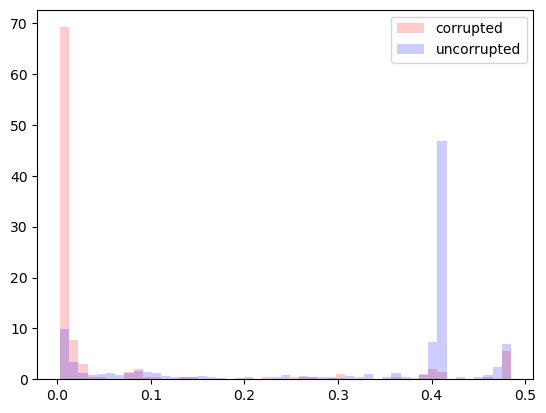

In [24]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[noise_idx], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[not_noise_idx], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

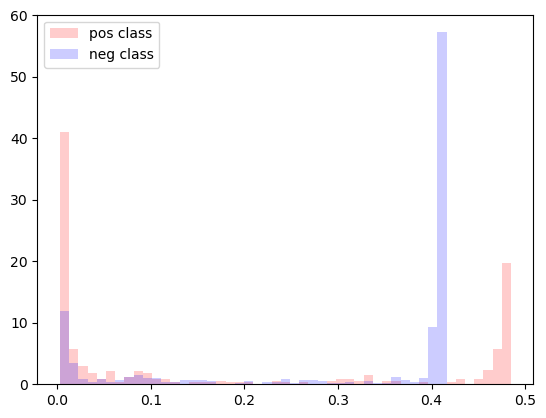

In [25]:
pos_class_idx = y_train.nonzero(as_tuple=True)[0]
neg_class_idx = np.delete(np.arange(y_train.shape[0]), pos_class_idx)

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[pos_class_idx], color='r', alpha=0.2, bins=bins, label='pos class', density=True)
plt.hist(vals_dvrl[neg_class_idx], color='b', alpha=0.2, bins=bins, label='neg class', density=True)
plt.legend()
plt.show()

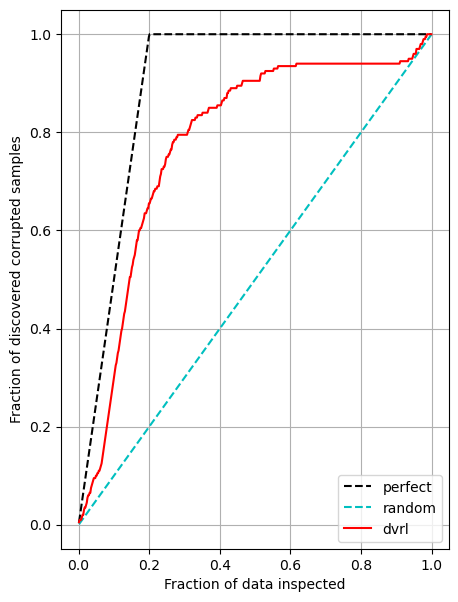

In [26]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvrl')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [30]:
model = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model.cpu(), 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    train_dataset   = copy.deepcopy(train_dataset), 
                    V               = DShap.V(copy.deepcopy(valid_dataset), roc_auc_score),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3)

tic = time.time() 
vals_shap = dshap.TMC(err=0.1, max_iterations=250, min_iterations=100, use_cuda=True, T=5, stopping_criteria=0.999)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

NameError: name 'train_dataset' is not defined

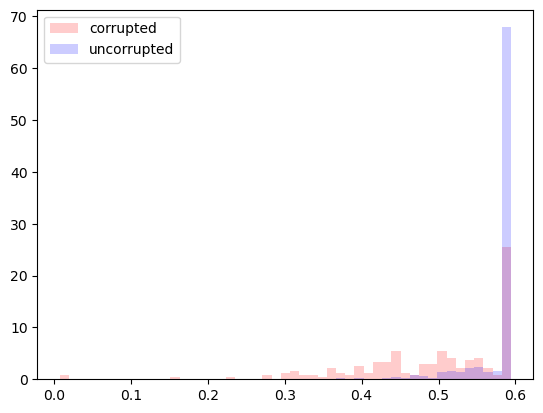

In [ ]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[noise_idx, 0].detach().cpu().numpy().ravel(), color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[not_noise_idx, 0].detach().cpu().numpy().ravel(), color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

In [ ]:
dvgs_data_values = vals_dvgs.mean(axis=1)
dvrl_data_values = vals_dvrl.detach().cpu().numpy().ravel() 
shap_data_values = vals_shap.ravel()

pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(dvgs_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(dvrl_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, shap_corr, p_perfect, p_random = get_corruption_scores(shap_data_values, noise_idx, train_size=1000, noise_prop=0.2)

(1000,)
(1000,)
(1000,)


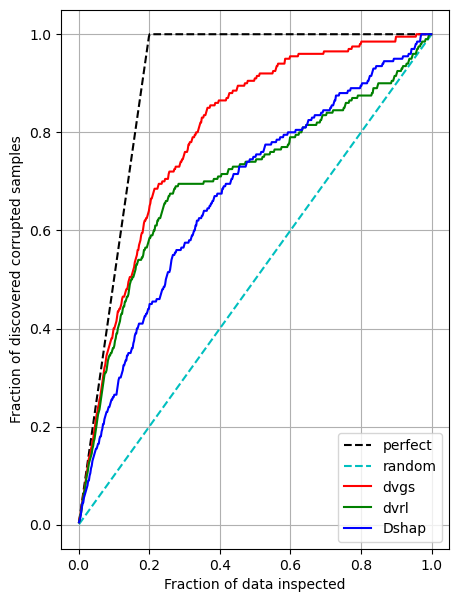

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.plot(pk, dvrl_corr, 'g-', label='dvrl')
plt.plot(pk, shap_corr, 'b-', label='Dshap')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [ ]:
model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.05, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long))
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1]) 

rand_data_values = np.random.normal(0,1,size=dvgs_data_values.shape)

qs = np.linspace(0., 0.5, 5)
bs = 256 
nw = 1 
lr = 1e-3 
ep = 100
rp = 3

dvgs_low, dvgs_high = get_filtered_scores(dvgs_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
dvrl_low, dvrl_high = get_filtered_scores(dvrl_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
shap_low, shap_high = get_filtered_scores(shap_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
rand_low, rand_high = get_filtered_scores(rand_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)


In [ ]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

plt.plot(qs, dvrl_low, 'g-', label='dvrl-low')
plt.plot(qs, dvrl_high, 'g--', label='dvrl-high')

plt.plot(qs, shap_low, 'b-', label='shap-low')
plt.plot(qs, shap_high, 'b--', label='shap-high')

plt.plot(qs, rand_low, 'c-', label='rand-low')
plt.plot(qs, rand_high, 'c--', label='rand-high')

plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.legend() 
plt.show()